<a href="https://colab.research.google.com/github/AkiHora/goznak_test_task/blob/main/audio_noise_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание

Задачи:
* классифицировать аудиодорожки на зашумленные и незашумленные
* отчистить зашумленные от шума

Данные находятся на диске. Чтобы их загрузить, примонтируем диск.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/goznak test task/train.part1.rar"
!unrar x -y "/content/drive/MyDrive/Colab Notebooks/goznak test task/train.part2.rar" 

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# Часть 1: классификация по шуму

## Обработка данных

In [3]:
from pathlib import Path

paths = list(Path('train/train').glob('**/*.npy'))
paths[:5]

[PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0078.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0019.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0067.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0002.npy'),
 PosixPath('train/train/noisy/2606/2606_130138_2606-130138-0029.npy')]

Аудиофайлы представляют собой мел-спектрограммы. Технически это матрицы, где по одной оси длина (время), по другой - частота.


In [5]:
from tqdm import tqdm

def get_mel_shapes(paths):
    shapes = []
    for path in tqdm(paths):
        shapes.append(np.load(path).shape[0])
    return np.array(shapes)
shapes = get_mel_shapes(paths)

100%|██████████| 24000/24000 [00:08<00:00, 2837.75it/s]


Посмотрим на распределение спектрограмм по длине (это не очень важно, но интересно глянуть).

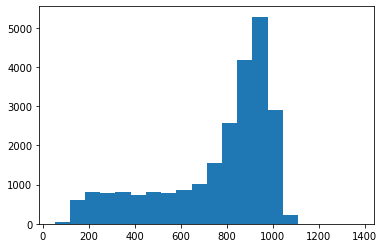

In [7]:
_ = plt.hist(shapes, bins=20)

Как видно, длины дорожек разные. Больше всего дорожек в районе длины 900-1000. Распределение ни равномерное, ни нормальное.

Теперь посмотрим на спектрограмму.

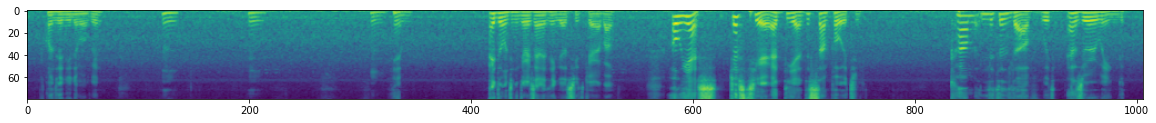

In [9]:
im = np.load(paths[0]).astype(np.float64)

plt.figure(figsize=(20, 10))
_ = plt.imshow(im.T)

Разделим данные на тренировочные и тестовые (валидационные) с соблюдением баланса зашумленных и чистых данных в каждой из выборок.

In [10]:
label_to_class = {
    'clean': 1,
    'noisy': 0,
}

path_to_class = lambda path: label_to_class[path.parents[1].stem]
y = np.array(list(map(path_to_class, paths)))

from sklearn.model_selection import train_test_split

train_paths, test_paths, y_train, y_test = train_test_split(paths, y, stratify=y)

In [11]:
len(train_paths), len(test_paths)

(18000, 6000)

Частоты всех спектрограмм одинаковые - 80. Но длина дорожек разная. Они понадобятся в будущем при создании датасета, так что достанем их.

In [13]:
train_shapes = get_mel_shapes(train_paths)
test_shapes = get_mel_shapes(test_paths)

100%|██████████| 6000/6000 [00:02<00:00, 2555.36it/s]


## Создание датасета

Создаем датасет, который мы будем использовать непосредственно при обучении. 

Модель классификации требует определенных размеров данных на входе. 
Поэтому мы будем брать спектрограммы и нарезать их так, чтобы фрагменты были одинаковой длины.

In [16]:
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

# Длина фрагмента для обучения
FR_SIZE = 128

class AudioDataset(Sequence):
    def __init__(self, paths,
                 y = None,
                 batch_size = 16,
                 fr_size = FR_SIZE,
                 shapes = None,
                 shuffle = True,
                    ):
        super().__init__()

        self.paths = np.array(paths)
        self.y = y
        self.fr_size = fr_size
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.shapes = shapes if not shapes is None else self._get_mel_shapes()
        self.number_of_samples = self._get_len() # self.__len__()
        self.number_of_batches = self.number_of_samples // self.batch_size

        self.dataset_indexes = np.arange(len(self.paths))

        if self.shuffle:
            np.random.shuffle(self.dataset_indexes)

        self.label_to_class = {
            'clean': 1,
            'noisy': 0,
        }

        self.get_fragment = self.get_fragment_generator()
        self.get_batch = np.vectorize(self.get_sample, signature='()->(h,w),()')
        self.path_to_class = lambda path: label_to_class[path.parents[1].stem]

    def get_fragment_generator(self):
        for path in self.paths[self.dataset_indexes]:
            class_ = self.path_to_class(path)
            mel_full = np.load(path).astype(np.float64)
            full_fragments_amount = len(mel_full) // self.fr_size
            residual_fragment_len = len(mel_full) % self.fr_size
            if residual_fragment_len >= self.fr_size // 2:
                padding = self.fr_size - residual_fragment_len
                mel_full = np.pad(mel_full, [(0, padding), (0, 0)])
                full_fragments_amount += 1
            else:
                mel_full = mel_full[:full_fragments_amount * self.fr_size]
            fragments = mel_full.reshape((full_fragments_amount, 
                                        self.fr_size,
                                        mel_full.shape[-1]))
            for fragment in fragments:
                yield fragment, class_

    def get_sample(self, i):
        try:
            x, y = next(self.get_fragment)
        except:
            self.get_fragment = self.get_fragment_generator()
            x, y = next(self.get_fragment)
        return x, y

    def __getitem__(self, i):
        return self.get_batch(np.arange(self.batch_size))
            
    def _get_mel_shapes(self):
        shapes = []
        for path in tqdm(self.paths):
            shapes.append(np.load(path).shape[0])
        return np.array(shapes)

    def _get_len(self):
        end_fragment = ((self.shapes % self.fr_size) > self.fr_size // 2).astype(np.int32)
        number_of_batches = self.shapes // self.fr_size + end_fragment
        return number_of_batches.sum()
        
    def __len__(self):
        return self.number_of_batches

    def show_sample(self):
        i = np.random.choice(self.dataset_indexes)
        sample = np.load(self.paths[self.dataset_indexes][i]).astype(np.float64)
        label = self.paths[self.dataset_indexes][i].parents[1].stem

        plt.figure(figsize=(20, 10))
        plt.title(label)
        plt.imshow(sample.T)

In [17]:
train_dataset = AudioDataset(train_paths, batch_size=32, shapes=train_shapes)
test_dataset = AudioDataset(test_paths, batch_size=512, shapes=test_shapes)

In [19]:
# Проверим корректность выдачи датасета
X, y = train_dataset[0]
X.shape, y.shape

((32, 128, 80), (32,))

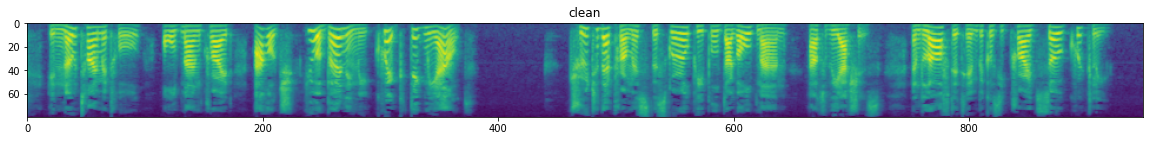

In [20]:
train_dataset.show_sample()

## Модель и обучение

Начнем с простой модели.

In [21]:
from keras.layers import Conv2D, Input, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, Conv1D, MaxPool1D, Dropout
from keras import Model

inputs = Input((FR_SIZE, 80))
x = Conv1D(filters=16, kernel_size=5, dilation_rate=2)(inputs)
x = MaxPool1D(4)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1)(x)
outputs = Activation('sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer='rmsprop',
              loss='bce',
              metrics=['accuracy'],
              )

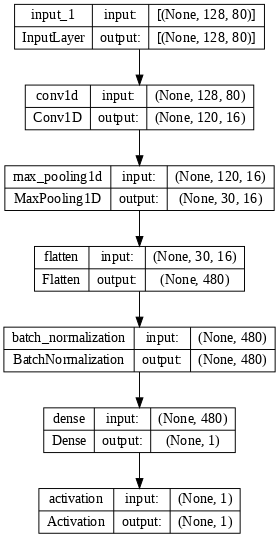

In [22]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=70)

In [23]:
history = model.fit(train_dataset, epochs=1, 
                    validation_data=test_dataset)

3336/3336 [==============================] - 59s 15ms/step - loss: 0.3782 - accuracy: 0.8375 - val_loss: 0.2714 - val_accuracy: 0.9014


Работает. Лосс не очень низкий, но явно не случайный. Точность это подтверждает. 

Теперь усложним модель.

In [24]:
inputs = Input((FR_SIZE, 80))
x = Conv1D(filters=16, kernel_size=5, dilation_rate=2)(inputs)
x = MaxPool1D(2)(x)
x = BatchNormalization()(x)
x = Conv1D(filters=32, kernel_size=3, dilation_rate=2)(x)
x = MaxPool1D(2)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
outputs = Activation('sigmoid')(x)
model = Model(inputs, outputs)

model.compile(optimizer='rmsprop',
              loss='bce',
              metrics=['accuracy'],
              )

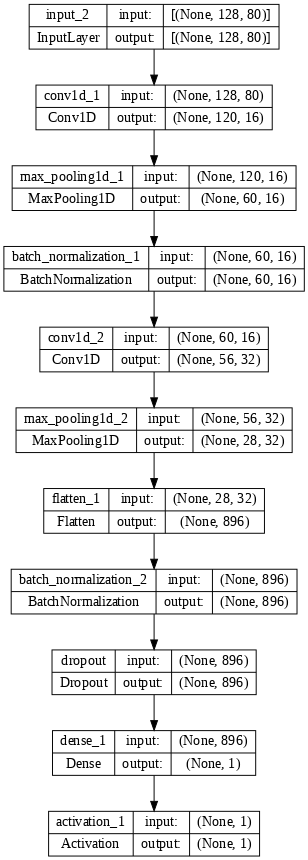

In [25]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=70)

In [26]:
history = model.fit(train_dataset, epochs=5, 
                    validation_data=test_dataset)

Epoch 1/5
3336/3336 [==============================] - 49s 14ms/step - loss: 0.3902 - accuracy: 0.8333 - val_loss: 0.2133 - val_accuracy: 0.9207
Epoch 2/5
3336/3336 [==============================] - 42s 12ms/step - loss: 0.3593 - accuracy: 0.8490 - val_loss: 0.2167 - val_accuracy: 0.9240
Epoch 3/5
3336/3336 [==============================] - 43s 13ms/step - loss: 0.3522 - accuracy: 0.8532 - val_loss: 0.2123 - val_accuracy: 0.9245
Epoch 4/5
3336/3336 [==============================] - 44s 13ms/step - loss: 0.3427 - accuracy: 0.8572 - val_loss: 0.2200 - val_accuracy: 0.9236
Epoch 5/5
3336/3336 [==============================] - 42s 13ms/step - loss: 0.3431 - accuracy: 0.8582 - val_loss: 0.1967 - val_accuracy: 0.9266


In [27]:
history.history

{'loss': [0.39024412631988525,
  0.359271764755249,
  0.35221928358078003,
  0.3426898717880249,
  0.3430553674697876],
 'accuracy': [0.8332677483558655,
  0.8490238785743713,
  0.8532392978668213,
  0.8572486042976379,
  0.8581759333610535],
 'val_loss': [0.21325108408927917,
  0.21666763722896576,
  0.2123057246208191,
  0.21997101604938507,
  0.19668494164943695],
 'val_accuracy': [0.9207427501678467,
  0.9239696264266968,
  0.9245357513427734,
  0.92357337474823,
  0.9265738129615784]}

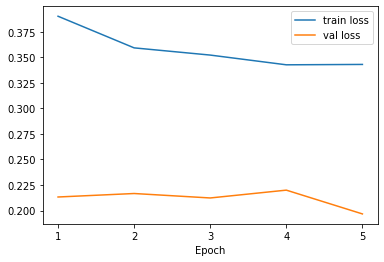

In [37]:
epoches = np.arange(1, len(history.history['loss']) + 1)
plt.plot(epoches, history.history['loss'], label='train loss')
plt.plot(epoches, history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.xticks(epoches)
_ = plt.legend()

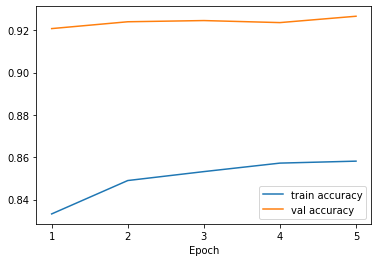

In [36]:
plt.plot(epoches, history.history['accuracy'], label='train accuracy')
plt.plot(epoches, history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.xticks(epoches)
_ = plt.legend()

Обучение классификации прошло успешно. Даже переобучения не произошло.

Что можно было бы улучшить?
* Добавить аугментацию: отражение, цветовой джиттер и пр.
* Попробовать другие модели (в том числе предобученные)
* Попробовать другие функции оптимизации

# Часть 2: фильтрация шума

Здесь почти все как при классификации. Но мы переделаем датасет так, чтобы на вход подавались зашумленные аудио, на выходе были их чистые аналоги. 

Также изменим модель.

## Обработка данных

Посмотрим, совпадают ли по форме файлы с одинаковыми названиями, но находящиеся в разных папках: clean и noise.


In [38]:
from pathlib import Path

clean_paths = list(Path('train/train/clean').glob('**/*.npy'))
noise_paths = list(Path('train/train/noisy').glob('**/*.npy'))
noise_paths[:5]

[PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0078.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0019.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0067.npy'),
 PosixPath('train/train/noisy/2606/2606_132102_2606-132102-0002.npy'),
 PosixPath('train/train/noisy/2606/2606_130138_2606-130138-0029.npy')]

In [39]:
import numpy as np
from tqdm import tqdm

clean_paths = sorted(clean_paths)
noisy_paths = sorted(noise_paths)

for clean_path, noisy_path in tqdm(zip(clean_paths, noisy_paths)):
    noised_path = str(clean_path).replace('clean', 'noisy')
    Error_path_msg = 'несовпадают названия путей \n{} \nи \n{}'.format(noised_path, noisy_path)
    assert noised_path == str(noisy_path), Error_path_msg
    clean_mel = np.load(clean_path)
    noisy_mel = np.load(noisy_path)
    Error_shape_msg = 'несовпадают формы путей: \n{} \nи \n{}'.format(clean_mel.shape, noisy_mel.shape)
    assert clean_mel.shape == noisy_mel.shape, Error_shape_msg
else:
    print('\nВсе зашумленные звуки имеют чистый аналог с той же формой mel')

12000it [00:07, 1564.72it/s]


Все зашумленные звуки имеют чистый аналог с той же формой mel


In [40]:
from tqdm import tqdm

def get_mel_shapes(paths):
    shapes = []
    for path in tqdm(paths):
        shapes.append(np.load(path).shape[0])
    return np.array(shapes)
shapes = get_mel_shapes(clean_paths)

100%|██████████| 12000/12000 [00:03<00:00, 3418.70it/s]


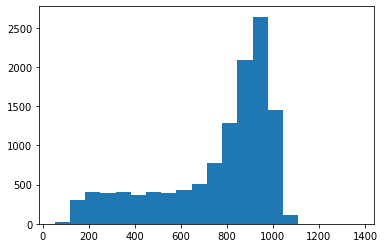

In [42]:
_ = plt.hist(shapes, bins=20)

Обучение будет происходить так же по фрагментам дорожек.

## Создание датасета

In [57]:
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

FR_SIZE = 128

class NoisyFiltherDataset(Sequence):
    def __init__(self, noisy_paths, 
                 clean_paths = None,
                 mode = 'test',
                 batch_size = 8,
                 fr_size = FR_SIZE,
                 shapes = None,
                 shuffle = True,
                    ):
        super().__init__()

        assert mode in ['train', 'val', 'test'], 'Ошибка: неверный мод ' + mode
        if mode != 'test':
            assert not clean_paths is None, 'Ошибка: не получены чистые аудио'
            self.clean_paths = np.array(clean_paths)
        else:
            er_msg = 'Ошибка: clean_paths должно быть None при mode == "test"'
            assert clean_paths is None, er_msg

            # Зададим self.clean_paths как массив, так как иначе Colab будет ругаться
            self.clean_paths = np.empty(noisy_paths.shape)
        self.mode = mode
        self.noisy_paths = np.array(noisy_paths)
        self.fr_size = fr_size
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.shapes = shapes if not shapes is None else self._get_mel_shapes()
        self.number_of_samples = self._get_len() # self.__len__()
        self.number_of_batches = self.number_of_samples // self.batch_size

        self.dataset_indexes = np.arange(len(self.noisy_paths))

        if self.shuffle:
            np.random.shuffle(self.dataset_indexes)

        self.get_fragment = self.get_fragment_generator()

        signature = '()->(h,w,c)'
        if mode != 'test':
            signature += ',(h,w,c)'
        self.get_batch = np.vectorize(self.get_sample, signature=signature)

    def get_fragment_generator(self):
        Error_shape_msg = '\nНесовпадение форм: {} и {}'
        for i in self.dataset_indexes:
            noisy_path = self.noisy_paths[i]
            noisy_mel = np.load(noisy_path).astype(np.float64)
            if self.mode != 'test':
                clean_path = self.clean_paths[i]
                clean_mel = np.load(clean_path).astype(np.float64)
                er_msg = Error_shape_msg.format(noisy_mel.shape, 
                                                clean_mel.shape)
                assert noisy_mel.shape == clean_mel.shape, er_msg

            full_fragments_amount = len(noisy_mel) // self.fr_size
            residual_fragment_len = len(noisy_mel) % self.fr_size
            if residual_fragment_len >= self.fr_size // 2:
                padding = self.fr_size - residual_fragment_len
                noisy_mel = np.pad(noisy_mel, [(0, padding), (0, 0)])
                full_fragments_amount += 1
                if self.mode != 'test':
                    clean_mel = np.pad(clean_mel, [(0, padding), (0, 0)])

            else:
                noisy_mel = noisy_mel[:full_fragments_amount * self.fr_size]
                if self.mode != 'test':
                    clean_mel = clean_mel[:full_fragments_amount * self.fr_size]

            noisy_fragments = noisy_mel.reshape((full_fragments_amount, 
                                        self.fr_size,
                                        noisy_mel.shape[-1], 1))
            if self.mode != 'test':
                clean_fragments = clean_mel.reshape((full_fragments_amount, 
                                            self.fr_size,
                                            clean_mel.shape[-1], 1))

                fragments = zip(noisy_fragments, clean_fragments)
            else:
                fragments = noisy_fragments.copy()

            for fragment in fragments:
                yield fragment

    def get_sample(self, i):
        try:
            fragment = next(self.get_fragment)
        except:
            self.get_fragment = self.get_fragment_generator()
            fragment = next(self.get_fragment)
        return fragment

    def __getitem__(self, i):
        return self.get_batch(np.arange(self.batch_size))
            
    def _get_mel_shapes(self):
        shapes = []
        for path in tqdm(self.noisy_paths):
            shapes.append(np.load(path).shape[0])
        return np.array(shapes)

    def _get_len(self):
        end_fragment = ((self.shapes % self.fr_size) > self.fr_size // 2).astype(np.int32)
        number_of_batches = self.shapes // self.fr_size + end_fragment
        return number_of_batches.sum()
        
    def __len__(self):
        return self.number_of_batches

    def show_sample(self, model = None, show_diff=True):
        i = np.random.choice(self.dataset_indexes)
        noisy_path = self.noisy_paths[self.dataset_indexes][i]
        noisy_mel = np.load(noisy_path).astype(np.float64)

        plt.figure(figsize=(20, 10))
        plt.title('noisy_mel')
        plt.imshow(noisy_mel.T)
        plt.show()

        if self.mode != 'test':
            clean_path = self.clean_paths[self.dataset_indexes][i]
            clean_mel = np.load(clean_path).astype(np.float64)
            plt.figure(figsize=(20, 10))
            plt.title('clean_mel')
            plt.imshow(clean_mel.T)
            plt.show()

            if show_diff:
                diff = np.abs(noisy_mel - clean_mel)
                plt.figure(figsize=(20, 10))
                plt.title('noisy_mel - clean_mel')
                plt.imshow(diff.T)
                plt.show()

        if not model is None:
            padding = 4 - noisy_mel.shape[0] % 4
            x = np.pad(noisy_mel, [(0, padding), (0, 0)])
            x = x[None, :, :, None]
            pred = np.array(model(x))[0, :-padding, :, 0]

            plt.figure(figsize=(20, 10))
            plt.title('pred audio')
            plt.imshow(pred.T)
            plt.show()

            if show_diff:
                diff = np.abs(noisy_mel - pred)
                plt.figure(figsize=(20, 10))
                plt.title('noisy_mel - pred')
                plt.imshow(diff.T)
                plt.show()

                diff = np.abs(clean_mel - pred)
                plt.figure(figsize=(20, 10))
                plt.title('clean_mel - pred')
                plt.imshow(diff.T)
                plt.show()

In [44]:
from sklearn.model_selection import train_test_split

X_train_paths, X_val_paths, y_train_paths, y_val_paths = train_test_split(noisy_paths, clean_paths)

In [45]:
train_shapes = get_mel_shapes(X_train_paths)
val_shapes = get_mel_shapes(X_val_paths)

100%|██████████| 3000/3000 [00:01<00:00, 2495.02it/s]


In [58]:
train_dataset = NoisyFiltherDataset(X_train_paths, y_train_paths,
                              mode='train',
                              shapes=train_shapes)

val_dataset = NoisyFiltherDataset(X_val_paths, y_val_paths,
                              mode='val',
                              shapes=val_shapes)

Посмотрим, как дорожка выглядит в зашумленном и чистом виде.

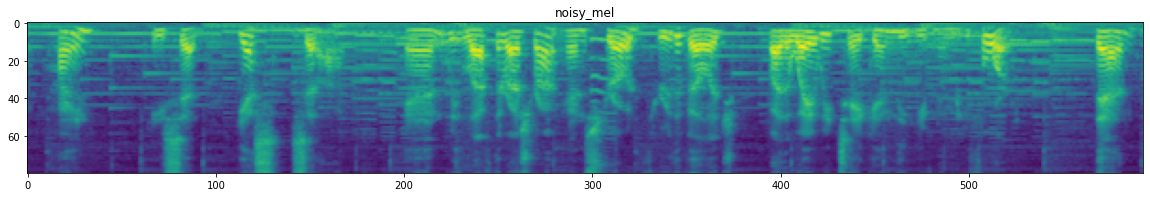

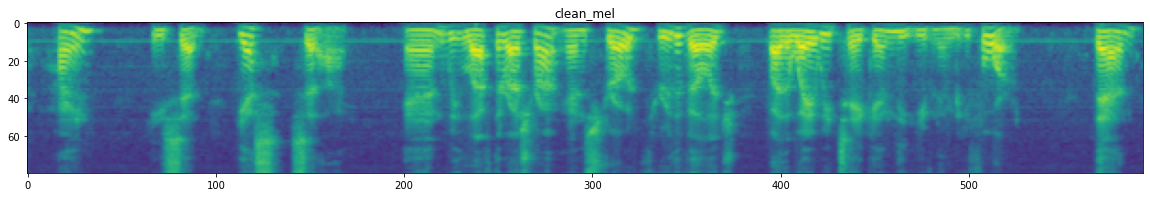

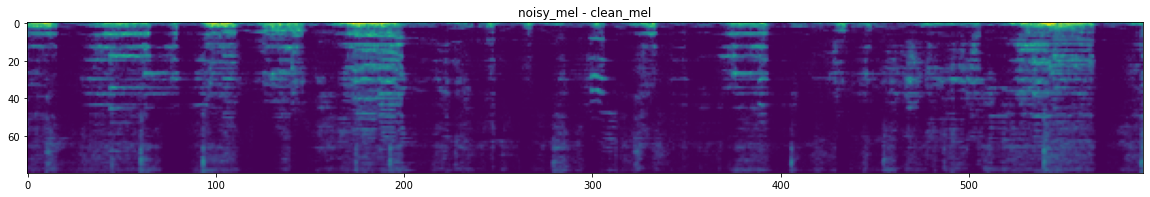

In [48]:
train_dataset.show_sample()

## Модель и обучение

Сделаем архитектуру по типу UNet.

In [49]:
from keras.layers import Input, Concatenate, Conv2D, Activation, MaxPooling2D, UpSampling2D, BatchNormalization, SpatialDropout2D
from keras import Model

def create_model(input_shape):
    inputs = Input(shape=input_shape)

    conv_1_1 = Conv2D(32, (3, 3), padding='same', dilation_rate=2)(inputs)
    conv_1_1 = BatchNormalization()(conv_1_1)
    conv_1_1 = Activation('relu')(conv_1_1)
    pool_1 = MaxPooling2D(2)(conv_1_1)

    conv_1_2 = Conv2D(64, (3, 3), padding='same', dilation_rate=2)(pool_1)
    conv_1_2 = BatchNormalization()(conv_1_2)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_2 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_2_1 = BatchNormalization()(conv_2_1)
    conv_2_1 = SpatialDropout2D(0.2)(conv_2_1)
    conv_2_1 = Activation('relu')(conv_2_1)

    up_1 = UpSampling2D(2, interpolation='bilinear')(conv_2_1)
    conc_1 = Concatenate()([conv_1_2, up_1])

    conv_2_2 = Conv2D(64, (3, 3), padding='same', dilation_rate=2)(conc_1)
    conv_2_2 = BatchNormalization()(conv_2_2)
    conv_2_2 = Activation('relu')(conv_2_2)
    conv_2_2 = SpatialDropout2D(0.2)(conv_2_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_2_2)
    conc_2 = Concatenate()([conv_1_1, up_2])

    conv_up_4_1 = Conv2D(32, (3, 3), padding='same', dilation_rate=2)(conc_2)
    conv_up_4_1 = BatchNormalization()(conv_up_4_1)
    conv_up_4_1 = Activation('relu')(conv_up_4_1)
    conv_up_4_1 = SpatialDropout2D(0.2)(conv_up_4_1)

    conv_up_4_2 = Conv2D(1, (3, 3), padding='same', dilation_rate=2)(conv_up_4_1)
    outputs = BatchNormalization()(conv_up_4_2)

    return Model(inputs=inputs, outputs=outputs)

Так как все слои модели не требуют определенной формы данных 
(кроме числа измерений и числа каналов)
то мы можем себе позволить не ограничиваться конкретной длиной входа аудио.
Это позволит нам обучать модель на фрагментах аудио одинаковой формы, но при этом тестировать модель мы можем на аудио разных форм. Это удобно, так как не придется шаблонизировать тестовые данные, предсказания которых нужно получить в той же форме.

In [50]:
model_filter = create_model(input_shape = (None, 80, 1))

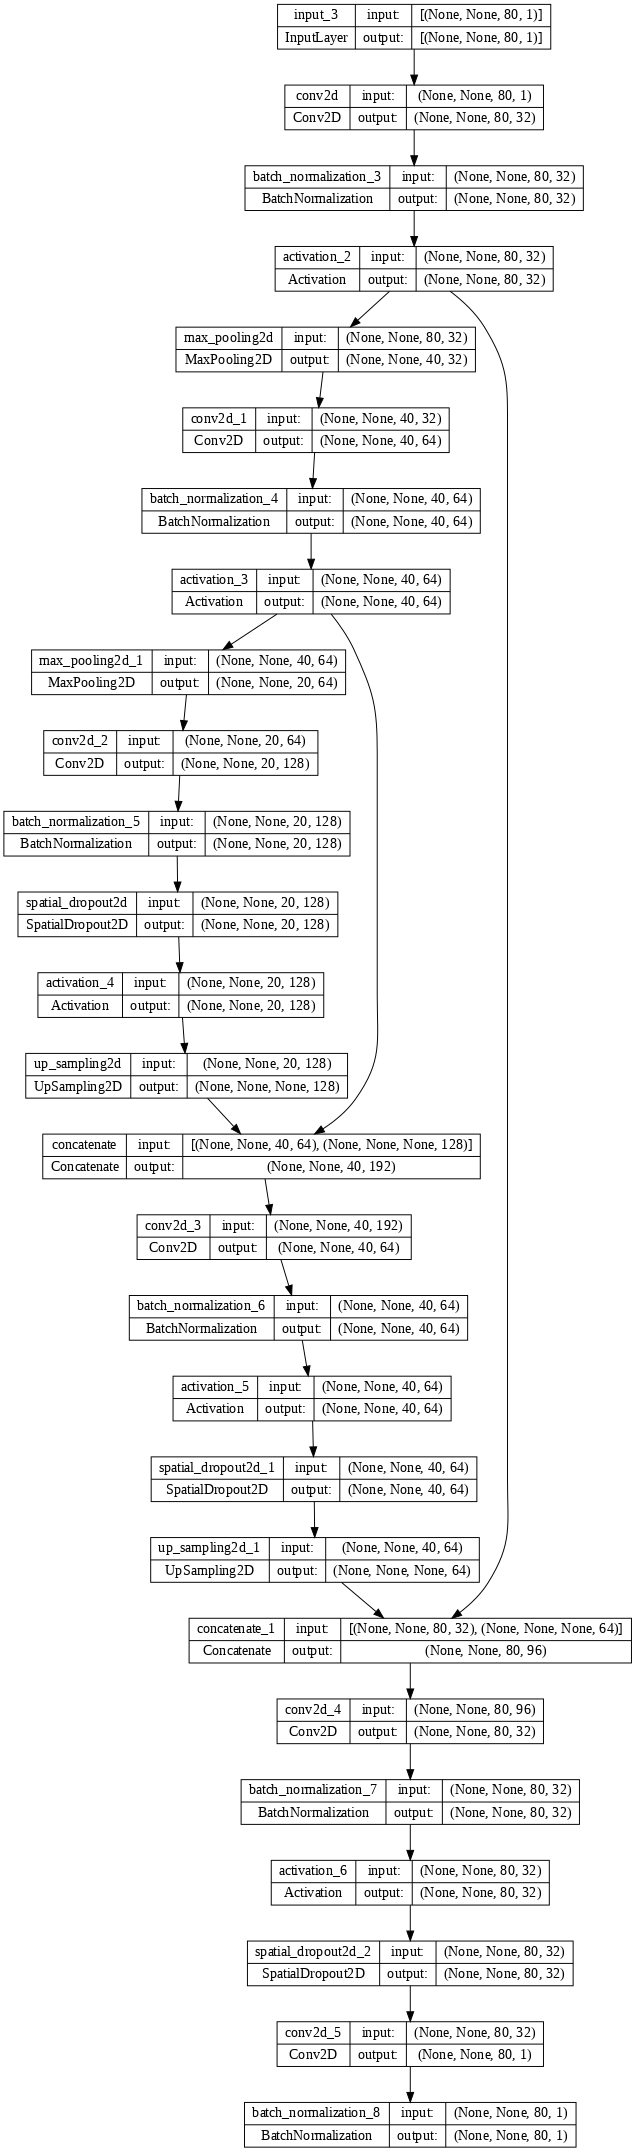

In [51]:
from keras.utils import plot_model

plot_model(model_filter, show_shapes=True, dpi=70)

In [52]:
model_filter.compile(optimizer='adam',
              loss='mse',
              )

In [53]:
history = model_filter.fit(train_dataset, epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
6675/6675 [==============================] - 192s 28ms/step - loss: 0.0703 - val_loss: 0.0448
Epoch 2/5
6675/6675 [==============================] - 193s 29ms/step - loss: 0.0507 - val_loss: 0.0449
Epoch 3/5
6675/6675 [==============================] - 186s 28ms/step - loss: 0.0491 - val_loss: 0.0426
Epoch 4/5
6675/6675 [==============================] - 187s 28ms/step - loss: 0.0482 - val_loss: 0.0395
Epoch 5/5
6675/6675 [==============================] - 186s 28ms/step - loss: 0.0474 - val_loss: 0.0418


Получился небольшой лосс. Это хороший результат.

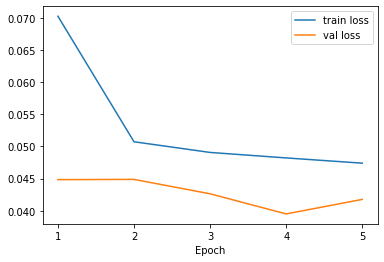

In [54]:
epoches = np.arange(1, len(history.history['loss']) + 1)
plt.plot(epoches, history.history['loss'], label='train loss')
plt.plot(epoches, history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.xticks(epoches)
_ = plt.legend()

Посмотрим как выглядит результат на картинке. Выведем шумный сигнал, чистый, предсказанный, а так же сравним их попарно. В идеальном случае картинка с разницей предсказания и чистым звуком должна выглядеть одноцветной.

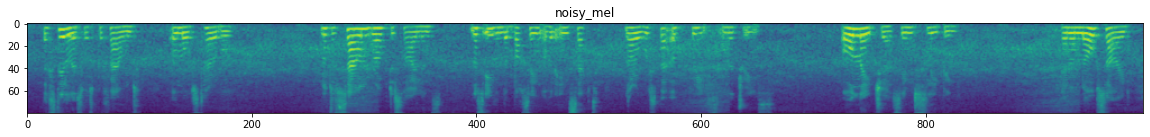

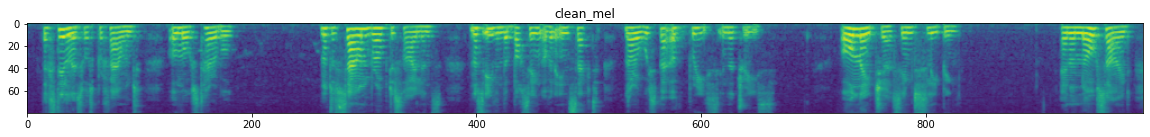

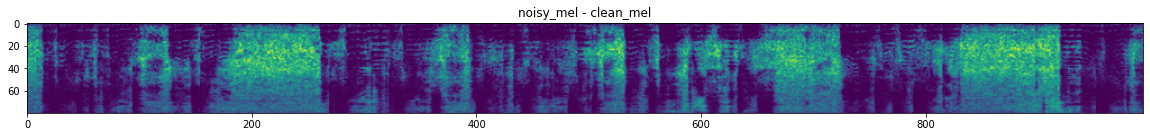

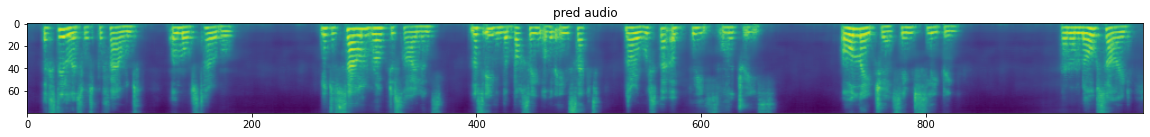

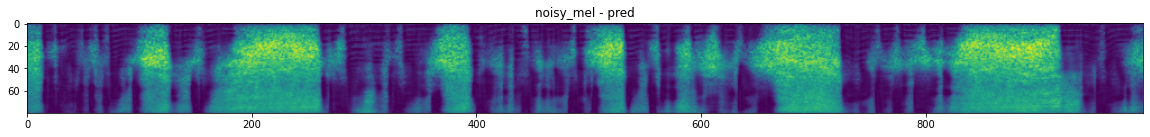

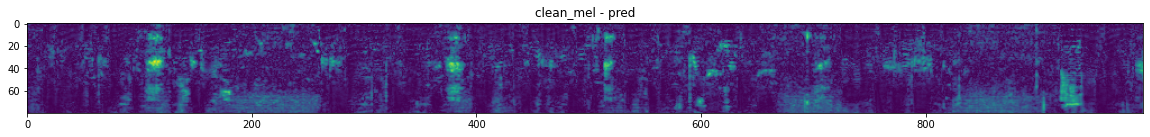

In [59]:
val_dataset.show_sample(model_filter, show_diff=True)

Как видно, разница между чистым аудио и предсказанным действительно небольшая. По всей аудиодорожке есть цветные вкрапления - разница между чистым сигналом и предсказанным - но они незначительны.

Теперь прогоним через модель тестовые данные и запишем их в виде файлов.

In [ ]:
!unrar x "/content/drive/MyDrive/Colab Notebooks/goznak test task/val.rar" 

In [61]:
test_paths = list(Path('val/val').glob('**/*.npy'))

test_paths[:5]

[PosixPath('val/val/noisy/4767/4767_66411_4767-66411-0059.npy'),
 PosixPath('val/val/noisy/4767/4767_66411_4767-66411-0061.npy'),
 PosixPath('val/val/noisy/4767/4767_66411_4767-66411-0020.npy'),
 PosixPath('val/val/noisy/4767/4767_66411_4767-66411-0032.npy'),
 PosixPath('val/val/noisy/5636/5636_41795_5636-41795-0030.npy')]

In [62]:
import os
output_folder = 'preds'

Path(output_folder).mkdir(parents=True, exist_ok=True)

In [63]:
for path in test_paths:
    inner_folder = path.parents[0].stem
    Path(output_folder + '/' + inner_folder).mkdir(parents=True, exist_ok=True)

In [66]:
def pred_test_data(test_paths, model, output_folder=output_folder):
    for path in tqdm(test_paths):
        orig_x = np.load(path).astype(np.float64)
        padding = 4 - orig_x.shape[0] % 4
        x = np.pad(orig_x, [(0, padding), (0, 0)])
        x = x[None, :, :, None]
        pred = model(x)[0, :-padding, :, 0]
        assert pred.shape == orig_x.shape, '{}, {}'.format(orig_x.shape, pred.shape)

        pred_path = 'preds/' + path.parents[0].stem + '/' + path.name
        with open(pred_path, 'wb') as f:
            np.save(f, pred)

pred_test_data(test_paths, model_filter, output_folder=output_folder)

100%|██████████| 4000/4000 [02:05<00:00, 31.85it/s]


Проверим, что данные записались нормально.

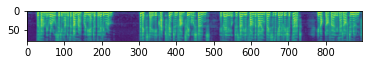

In [67]:
preds_path = list(Path('preds').glob('**/*.npy'))
x = np.load(preds_path[1000])
plt.imshow(x.T)

Архивируем и скачиваем

In [ ]:
!zip -r /content/preds.zip /content/preds

In [69]:
from google.colab import files
files.download("/content/preds.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>